In [1]:
!python -V

Python 3.9.21


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
#import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
import mlflow

In [7]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")

In [8]:
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops_zoomcamp_hw/02-experiment-tracking/mlruns/1', creation_time=1747389772146, experiment_id='1', last_update_time=1747389772146, lifecycle_stage='active', name='nyc-taxi-experiment', tags={'mlflow.note.content': '1'}>

In [9]:
df_val = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')
df_val['duration'] = (df_val['lpep_dropoff_datetime'] - df_val['lpep_pickup_datetime']).dt.total_seconds() / 60
df_val = df_val[(df_val['duration'] >= 1) & (df_val['duration'] <= 60)]

In [10]:
#df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

df["weekday"] = df.lpep_pickup_datetime.dt.weekday
df["hour"] =  df.lpep_pickup_datetime.dt.hour

categorical = ['PULocationID', 'DOLocationID',  'weekday', 'hour']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [11]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,weekday,hour
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333,4,0
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000,4,0
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667,4,0
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333,3,23
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667,4,0


In [12]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

print("Feature matrix dimensions:", X_train.shape)

Feature matrix dimensions: (73908, 538)


In [13]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred)

95.25045983499172

/tmp/ipykernel_49449/4270073092.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


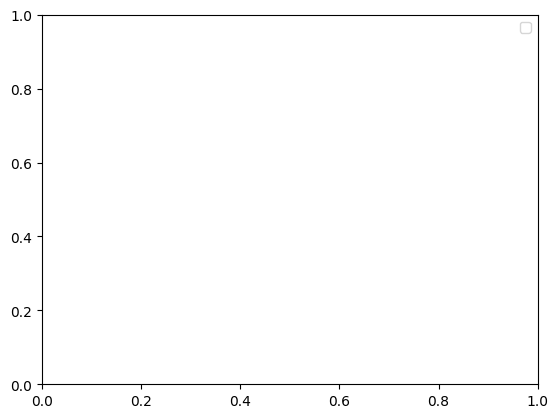

In [14]:
#sns.distplot(y_pred, label='prediction')
#sns.distplot(y_train, label='actual')

plt.legend()

In [15]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [16]:
#df_train = read_dataframe('./data/green_tripdata_2023-01.parquet')
#df_val = read_dataframe('./data/green_tripdata_2023-02.parquet')

In [17]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')
df_train.to_parquet('data/green_tripdata_2021-01.parquet')
df_val.to_parquet('data/green_tripdata_2021-02.parquet')

In [18]:
len(df_train), len(df_val)

(73908, 61921)

In [19]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [20]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [21]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

np.sqrt(mean_squared_error(y_val, y_pred))

np.float64(7.758715208009878)

In [23]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [24]:
with mlflow.start_run():

    mlflow.set_tag("developer", "johndoe")
    mlflow.log_param("train-data-path", "green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "green_tripdata_2021-02.parquet")
    alpha = 0.1
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_train)

    rmse= np.sqrt(mean_squared_error(y_train, y_pred))
    mlflow.log_metric("rmse", rmse)

In [25]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [ ]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

: 

In [ ]:

params = {
    'max_depth': 60,
    'learning_rate': 0.10027586753294233,
    'reg_lambda': 0.20074980286498087,
    'reg_alpha': 0.15788520719314586,
    'min_child_weight': 0.5999999488650849,
    'objective': 'reg:linear',
    'seed': 42
}


mlflow.xgboost.autolog()
booster = xgb.train(
            params = params, 
            dtrain = train, 
            num_boost_round = 1000, 
            evals = [(valid, "validation")],
            early_stopping_rounds = 50
        )


2025/05/16 15:34:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b534c63cdf804e53b58f9fb1ec5569a3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


In [ ]:
def objective(params):

    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)

        booster = xgb.train(
            params = params, 
            dtrain = train, 
            num_boost_round = 1000, 
            evals = [(valid, "validation")],
            early_stopping_rounds = 50
        )
        y_pred = booster.predict(valid)
        rmse = np.sqrt( mean_squared_error(y_val, y_pred))
        print("rmse", rmse)
        mlflow.log_metric("rmse", rmse)
    
    return {
        'loss': rmse,
        'status': STATUS_OK
    }

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_lambda': hp.loguniform('reg_lambda', -5, -1),
    'reg_alpha': hp.loguniform('reg_alpha', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42 
}

best_result = fmin(fn=objective,
                   space=search_space,
                   algo=tpe.suggest,
                   max_evals=50,
                   trials=Trials())